In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

store = pd.HDFStore('/Users/jiaqizhang/Documents/innovation_day/stock/data/base_store.h5')
base = store['base'] 

base_f = base[base.closed_diff.notnull()]
base_f = base_f[base_f.issue_date.notnull()]
base_f = base_f[base_f.eqy_belongto_parcomsh.notnull() & (base_f.eqy_belongto_parcomsh > 0.0)]
base_f = base_f[base_f.np_belongto_parcomsh.notnull() & (base_f.np_belongto_parcomsh > 0.0) ]
base_f = base_f[base_f.days_since_ipo > 180]
base_f = base_f.fillna(0)


In [10]:
base_f[base_f.code == '000300.sh'].head()

,code,close,turn,mkt_cap,open,vol,adjfactor,amount,swing,high,...,tot_liab,eqy_belongto_parcomsh,cap_rsrv,surplus_rsrv,undistributed_profit,other_equity_instruments_PRE,tot_liab_shrhldr_eqy,days_since_ipo,pe,pb


# Calculate PE/PB/PS

In [3]:
# Calculate PE/PB/PS
base_f['pe'] = base_f['mkt_cap'] / base_f['np_belongto_parcomsh']
base_f['pb'] = base_f['mkt_cap'] / base_f['eqy_belongto_parcomsh']
#base_f['ps'] = base_f['mkt_cap'] / base_f['opprofit']


In [4]:
#base_3 = base_f[base_f.weekday == 3]
base_3 = base_f

dev = base_3[base_3.transaction_date >= pd.to_datetime('2012-01-01')]
dev = dev[dev.transaction_date < pd.to_datetime('2015-01-01')]

val = base_3[base_3.transaction_date < pd.to_datetime('2013-01-01')]
oot = base_3[base_3.transaction_date >= pd.to_datetime('2015-01-01')]


In [5]:
meta_variables = ['adjfactor', 'code', 'transaction_date', 'ipo_date', 'out_date', 'close_7d', 'open_7d', 'closed_diff', 'issue_date']
all_vars = base_f.columns
key_vars = ['code', 'transaction_date']
target_var = ['closed_diff']
candidate_vars = [var for var in all_vars if var not in meta_variables]
candidate_vars

['close',
 'turn',
 'mkt_cap',
 'open',
 'vol',
 'amount',
 'swing',
 'high',
 'low',
 'weekday',
 'opprofit',
 'non_oper_rev',
 'non_oper_exp',
 'tot_profit',
 'tax',
 'net_profit_is',
 'minority_int_inc',
 'np_belongto_parcomsh',
 'net_cash_flows_oper_act',
 'stot_cash_outflows_oper_act',
 'stot_cash_outflows_inv_act',
 'net_cash_flows_inv_act',
 'stot_cash_outflows_fnc_act',
 'net_cash_flows_fnc_act',
 'monetary_cap',
 'tradable_fin_assets',
 'notes_rcv',
 'acct_rcv',
 'oth_rcv',
 'prepay',
 'dvd_rcv',
 'int_rcv',
 'inventories',
 'tot_cur_assets',
 'fin_assets_avail_for_sale',
 'held_to_mty_invest',
 'invest_real_estate',
 'long_term_eqy_invest',
 'long_term_rec',
 'fix_assets',
 'intang_assets',
 'r_and_d_costs',
 'goodwill',
 'long_term_deferred_exp',
 'deferred_tax_assets',
 'tot_non_cur_assets',
 'tot_assets',
 'st_borrow',
 'notes_payable',
 'acct_payable',
 'adv_from_cust',
 'empl_ben_payable',
 'taxes_surcharges_payable',
 'tot_acct_payable',
 'int_payable',
 'dvd_payable',


In [6]:
candidate_vars = ['swing','days_since_ipo','turn','vol','amount','low','high','open','close','pb','mkt_cap','pe']

dev_x = dev[candidate_vars]
dev_y = dev[target_var].as_matrix().flatten() * -1.0
dev_y = [1 if var > 0.03 else 0 for var in dev_y]

val_x = val[candidate_vars]
val_y = val[target_var].as_matrix().flatten() * -1.0
val_y = [1 if var > 0.03 else 0 for var in val_y]

oot_x = oot[candidate_vars]
oot_y = oot[target_var].as_matrix().flatten() * -1.0
oot_y = [1 if var > 0.03 else 0 for var in oot_y]


# Normalization
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(dev_x)
dev_n_x = scaler.transform(dev_x)
val_n_x = scaler.transform(val_x)
oot_n_x = scaler.transform(oot_x)


# RandomForest model

In [7]:
from sklearn.ensemble import ExtraTreesClassifier 

clf = ExtraTreesClassifier(n_estimators=100, max_features = len(candidate_vars))

clf.fit(dev_n_x, dev_y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=12, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [8]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(dev_n_x.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, dev_x.columns[indices[f]], importances[indices[f]]))
    


Feature ranking:
1. feature days_since_ipo (0.108298)
2. feature swing (0.103350)
3. feature turn (0.089289)
4. feature pb (0.088360)
5. feature pe (0.088309)
6. feature mkt_cap (0.086320)
7. feature vol (0.085319)
8. feature amount (0.083542)
9. feature open (0.069394)
10. feature close (0.068954)
11. feature low (0.064466)
12. feature high (0.064399)


In [9]:
pred_y = clf.predict_proba(dev_n_x)
dev_scores = pd.DataFrame(pred_y)
dev_scores['tag'] = pd.Series(dev_y)

pred_y = clf.predict_proba(val_n_x)
val_scores = pd.DataFrame(pred_y)
val_scores['tag'] = pd.Series(val_y)

pred_y = clf.predict_proba(oot_n_x)
oot_scores = pd.DataFrame(pred_y)
oot_scores['tag'] = pd.Series(oot_y)

In [11]:
from sklearn.metrics import roc_curve, auc

#pred_y = clf.predict(oot_n_x)
dev_fpr, dev_tpr, _ = roc_curve(dev_scores['tag'], dev_scores[1], pos_label = 1)
dev_auc = auc(dev_fpr, dev_tpr)

val_fpr, val_tpr, _ = roc_curve(val_scores['tag'], val_scores[1], pos_label = 1)
val_auc = auc(val_fpr, val_tpr)

oot_fpr, oot_tpr, _ = roc_curve(oot_scores['tag'], oot_scores[1], pos_label = 1)
oot_auc = auc(oot_fpr, oot_tpr)

print ("dev auc: %d; val auc: %d; oot aud: %d", dev_auc, val_auc, oot_auc)

('dev auc: %d; val auc: %d; oot aud: %d', 1.0, 0.93373505906767762, 0.52295068120070465)


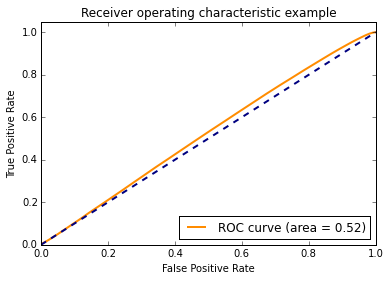

In [12]:
plt.figure()
lw = 2
plt.plot(oot_fpr, oot_tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % oot_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [13]:
oot_scores[oot_scores[1] > 0.7].groupby('tag').count()

,0,1
tag,,
0,1381,1381
1,1237,1237


In [14]:
oot_scores.groupby('tag').count()

,0,1
tag,,
0,637646,637646
1,297976,297976


# Evaluate

In [15]:
oot_re = oot.reset_index()
oot_re['predict'] = oot_scores[1]
oot_re['tag'] = oot_scores['tag']

oot_re['gain'] = (oot_re['close_7d'] - oot_re['close']) / oot_re['close']

keep_vars = ['code', 'transaction_date', 'close', 'close_7d', 'predict', 'tag',
            'swing',
'days_since_ipo',
'turn',
'vol',
'amount',
'low',
'high',
'open',
'pb',
'mkt_cap',
'pe', 'gain'] 

oot_re = oot_re[keep_vars]




In [16]:
oot_gain = oot_re[oot_re.predict > 0.7 ]
oot_gain = oot_gain[oot_gain.transaction_date > pd.to_datetime('2016-01-01')]
oot_gain = oot_gain[['transaction_date', 'gain', 'days_since_ipo']]

gain_summary= oot_gain.groupby('transaction_date').mean()

gain_summary.gain.describe()

count    151.000000
mean       0.034299
std        0.113418
min       -0.250220
25%       -0.012684
50%        0.000000
75%        0.057341
max        0.611478
Name: gain, dtype: float64

In [17]:
oot_gain = oot_re[oot_re.predict > 0.75 ]
oot_gain = oot_gain[oot_gain.transaction_date > pd.to_datetime('2016-01-01')]
oot_gain = oot_gain[['transaction_date', 'gain', 'days_since_ipo']]

gain_summary= oot_gain.groupby('transaction_date').mean()

gain_summary.gain.describe()

count    87.000000
mean      0.070970
std       0.196829
min      -0.284810
25%      -0.021392
50%       0.000000
75%       0.147041
max       0.612579
Name: gain, dtype: float64

In [18]:
oot_gain = oot_re[oot_re.predict > 0.8 ]
oot_gain = oot_gain[oot_gain.transaction_date > pd.to_datetime('2015-01-01')]
oot_gain = oot_gain[['transaction_date', 'gain', 'days_since_ipo']]

gain_summary= oot_gain.groupby('transaction_date').mean()

gain_summary.gain.describe()

count    229.000000
mean       0.138534
std        0.218668
min       -0.364603
25%        0.000000
50%        0.086154
75%        0.280484
max        0.612587
Name: gain, dtype: float64

In [19]:
oot_gain = oot_re[oot_re.predict > 0.8 ]
oot_gain = oot_gain[oot_gain.transaction_date > pd.to_datetime('2015-01-01')]
oot_gain = oot_gain.reset_index()

oot_gain = oot_gain.sort(['transaction_date', 'days_since_ipo'], ascending=[1, 0])
oot_gain[['transaction_date', 'days_since_ipo', 'gain', 'code', 'tag', 'predict', 'close', 'close_7d']]



/Users/jiaqizhang/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,transaction_date,days_since_ipo,gain,code,tag,predict,close,close_7d
24,2015-01-05,7691.0,-0.034571,000546.sz,0,0.84,7.81,7.54
556,2015-01-05,7605.0,-0.023684,600844.sh,0,0.97,7.60,7.42
73,2015-01-05,6066.0,0.024390,000811.sz,0,0.98,11.89,12.18
345,2015-01-05,4382.0,-0.032491,600030.sh,0,0.89,33.24,32.16
681,2015-01-05,1774.0,-0.010195,601688.sh,0,0.90,23.54,23.30
171,2015-01-05,1559.0,0.106845,002482.sz,1,0.92,5.99,6.63
590,2015-01-05,1413.0,0.079585,601216.sh,1,1.00,2.89,3.12
286,2015-01-05,1236.0,0.261015,300253.sz,1,0.81,17.93,22.61
314,2015-01-05,343.0,0.215475,300377.sz,1,0.87,20.42,24.82
557,2015-01-06,7606.0,-0.015789,600844.sh,0,0.97,7.60,7.48


In [314]:
oot_week_count = oot_re[oot_re.predict > 0.7]['transaction_date'].reset_index()
oot_week_count.groupby('transaction_date').count()


,index
transaction_date,
2015-01-05,23
2015-01-06,14
2015-01-07,12
2015-01-08,22
2015-01-09,22
2015-01-12,29
2015-01-13,12
2015-01-14,17
2015-01-15,16


# LR model

In [20]:
from sklearn.linear_model import LogisticRegression

est = LogisticRegression()
est.fit(dev_n_x, dev_y)
print("LR interception")


lr_y = est.predict_proba(dev_n_x)
dev_lr_scores = pd.DataFrame(lr_y)
dev_lr_scores['tag'] = pd.Series(dev_y)

lr_y = est.predict_proba(val_n_x)
val_lr_scores = pd.DataFrame(lr_y)
val_lr_scores['tag'] = pd.Series(val_y)

lr_y = est.predict_proba(oot_n_x)
oot_lr_scores = pd.DataFrame(lr_y)
oot_lr_scores['tag'] = pd.Series(dev_y)

LR interception


In [21]:
print(est.coef_)
print(candidate_vars)

[[  2.34395953e-01  -6.36564941e-02  -9.21433202e-02  -4.59468794e-03
    2.94430179e-02   2.31706616e+00   1.21302602e+00   1.58246947e-02
   -3.57689263e+00   5.23949463e-03  -8.42122854e-02   3.57665527e-03]]
['swing', 'days_since_ipo', 'turn', 'vol', 'amount', 'low', 'high', 'open', 'close', 'pb', 'mkt_cap', 'pe']


In [22]:
print(est.intercept_ )

[-0.99765727]


In [23]:
dev_fpr, dev_tpr, _ = roc_curve(dev_lr_scores['tag'], dev_lr_scores[1], pos_label = 1)
dev_auc = auc(dev_fpr, dev_tpr)

val_fpr, val_tpr, _ = roc_curve(val_lr_scores['tag'], val_lr_scores[1], pos_label = 1)
val_auc = auc(val_fpr, val_tpr)

oot_fpr, oot_tpr, _ = roc_curve(oot_lr_scores['tag'], oot_lr_scores[1], pos_label = 1)
oot_auc = auc(oot_fpr, oot_tpr)

print ("dev auc: %d; val auc: %d; oot aud: %d", dev_auc, val_auc, oot_auc)

('dev auc: %d; val auc: %d; oot aud: %d', 0.57008626953383645, 0.5649008739400676, 0.50170575903817471)


In [24]:
oot_lr_scores[oot_lr_scores[1] > 0.8].groupby('tag').count()

,0,1
tag,,
0,396,396
1,133,133


In [25]:
oot_lr_scores.groupby('tag').count()

,0,1
tag,,
0,674609,674609
1,261013,261013


In [26]:
oot_re = oot.reset_index()
oot_re['predict'] = oot_lr_scores[1]
oot_re['tag'] = oot_lr_scores['tag']

oot_re['gain'] = (oot_re['close_7d'] - oot_re['close']) / oot_re['close']

keep_vars = ['code', 'transaction_date', 'close', 'close_7d', 'predict', 'tag',
            'swing',
'days_since_ipo',
'turn',
'vol',
'amount',
'low',
'high',
'open',
'pb',
'mkt_cap',
'pe', 'gain'] 

oot_re = oot_re[keep_vars]

oot_gain = oot_re[oot_re.predict > 0.7 ]
oot_gain = oot_gain[oot_gain.transaction_date > pd.to_datetime('2016-01-01')]
oot_gain = oot_gain[['transaction_date', 'gain', 'days_since_ipo']]

gain_summary= oot_gain.groupby('transaction_date').mean()

gain_summary.gain.describe()

count    38.000000
mean      0.002577
std       0.086787
min      -0.131330
25%      -0.059416
50%      -0.016931
75%       0.048678
max       0.285268
Name: gain, dtype: float64

In [28]:
oot_gain = oot_re[oot_re.predict > 0.6 ]
oot_gain = oot_gain[oot_gain.transaction_date > pd.to_datetime('2016-01-01')]
oot_gain = oot_gain[['transaction_date', 'gain', 'days_since_ipo']]

gain_summary= oot_gain.groupby('transaction_date').mean()

gain_summary.gain.describe()

count    68.000000
mean     -0.007849
std       0.110342
min      -0.275189
25%      -0.069538
50%      -0.019875
75%       0.031002
max       0.410476
Name: gain, dtype: float64

# GBDT

In [29]:
from sklearn.ensemble import GradientBoostingClassifier
est = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, subsample=0.9,
                                max_depth=5, random_state=0).fit(dev_n_x, dev_y)

In [30]:
est.oob_improvement_[0]

0.0031688521536232805

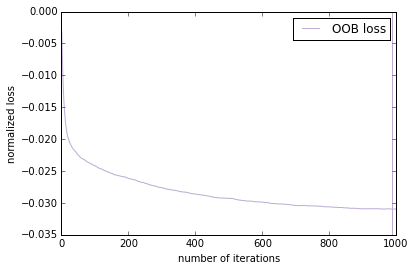

In [32]:


x = np.arange(1000) + 1
# negative cumulative sum of oob improvements
cumsum = -np.cumsum(est.oob_improvement_)


# min loss according to OOB
oob_best_iter = x[np.argmin(cumsum)]

# color brew for the three curves
oob_color = list(map(lambda x: x / 256.0, (190, 174, 212)))

# plot curves and vertical lines for best iterations
plt.plot(x, cumsum, label='OOB loss', color=oob_color)
plt.axvline(x=oob_best_iter, color=oob_color)

plt.legend(loc='upper right')
plt.ylabel('normalized loss')
plt.xlabel('number of iterations')

plt.show()


In [33]:
importances = est.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(dev_n_x.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, dev_x.columns[indices[f]], importances[indices[f]]))
    

Feature ranking:
1. feature days_since_ipo (0.180523)
2. feature pe (0.138244)
3. feature pb (0.123085)
4. feature mkt_cap (0.116785)
5. feature vol (0.066639)
6. feature amount (0.060805)
7. feature close (0.060301)
8. feature swing (0.058195)
9. feature turn (0.052292)
10. feature open (0.050762)
11. feature high (0.049903)
12. feature low (0.042466)


In [34]:
lr_y = est.predict_proba(dev_n_x)
dev_lr_scores = pd.DataFrame(lr_y)
dev_lr_scores['tag'] = pd.Series(dev_y)

lr_y = est.predict_proba(val_n_x)
val_lr_scores = pd.DataFrame(lr_y)
val_lr_scores['tag'] = pd.Series(val_y)

lr_y = est.predict_proba(oot_n_x)
oot_lr_scores = pd.DataFrame(lr_y)
oot_lr_scores['tag'] = pd.Series(dev_y)

In [35]:
dev_fpr, dev_tpr, _ = roc_curve(dev_lr_scores['tag'], dev_lr_scores[1], pos_label = 1)
dev_auc = auc(dev_fpr, dev_tpr)

val_fpr, val_tpr, _ = roc_curve(val_lr_scores['tag'], val_lr_scores[1], pos_label = 1)
val_auc = auc(val_fpr, val_tpr)

oot_fpr, oot_tpr, _ = roc_curve(oot_lr_scores['tag'], oot_lr_scores[1], pos_label = 1)
oot_auc = auc(oot_fpr, oot_tpr)

print ("dev auc: %d; val auc: %d; oot aud: %d", dev_auc, val_auc, oot_auc)

('dev auc: %d; val auc: %d; oot aud: %d', 0.65893630721663865, 0.61863545303207845, 0.50227544287654802)


In [36]:
oot_re = oot.reset_index()
oot_re['predict'] = oot_lr_scores[1]
oot_re['tag'] = oot_lr_scores['tag']

oot_re['gain'] = (oot_re['close_7d'] - oot_re['close']) / oot_re['close']

keep_vars = ['code', 'transaction_date', 'close', 'close_7d', 'predict', 'tag',
            'swing',
'days_since_ipo',
'turn',
'vol',
'amount',
'low',
'high',
'open',
'pb',
'mkt_cap',
'pe', 'gain'] 

oot_re = oot_re[keep_vars]

oot_gain = oot_re[oot_re.predict > 0.7 ]
oot_gain = oot_gain[oot_gain.transaction_date > pd.to_datetime('2016-01-01')]
oot_gain = oot_gain[['transaction_date', 'gain', 'days_since_ipo']]

gain_summary= oot_gain.groupby('transaction_date').mean()

gain_summary.gain.describe()

count    188.000000
mean       0.002780
std        0.030222
min       -0.126754
25%       -0.009988
50%        0.002990
75%        0.018732
max        0.082615
Name: gain, dtype: float64

In [39]:
oot_scores = pd.HDFStore('/Users/jiaqizhang/Documents/innovation_day/stock/data/gbt_scores.h5')
oot_scores['gbt_scores'] = oot_re
oot_scores.close()